# Customer Lifetime Value (CLV) Prediction using SQL and Machine Learning

This project focuses on predicting customer revenue over the next 90 days using historical purchasing behavior. 
The goal is not only to build a predictive model but also to understand the key behavioral drivers that influence future customer value.

In [ ]:
import pandas as pd
import seaborn as sns

In [2]:
df=pd.read_csv("Data/online_retail.csv" , encoding="ISO-8859-1")

## 1. Problem Statement

In e-commerce businesses, a small percentage of customers often contribute a large portion of total revenue. Identifying and predicting high-value customers is essential for optimizing marketing strategies, improving retention, and increasing profitability.
The objective of this project is to:
- Predict future 90-day customer revenue using past transaction history.
- Identify key behavioral factors influencing customer lifetime value.
- Segment customers into value-based categories for strategic decision-making.


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## 2. Data Cleaning and Preparation

The dataset contains transactional records including invoice details, product information, quantity purchased, pricing, and customer identifiers.

Before modeling, the following preprocessing steps were performed:

- Removed records with missing CustomerID values.
- Excluded cancelled transactions (InvoiceNo starting with "C").
- Removed negative quantities and zero-priced entries.
- Converted InvoiceDate into proper datetime format.
- Created a TotalPrice variable (Quantity × UnitPrice).

These steps ensure the dataset reflects valid and meaningful customer purchasing behavior.

In [8]:
df = df.dropna(subset=["CustomerID"])

df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


In [9]:
df.shape
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## 3. Customer-Level Feature Engineering

To shift from transaction-level data to customer intelligence, transactional records were aggregated at the customer level.

The following behavioral features were created:

- **Past_Transactions** – Number of unique purchases.
- **Past_Revenue** – Total revenue generated historically.
- **Recency** – Days since last purchase.
- **Customer_Age** – Duration between first and last purchase.
- **Avg_Order_Value** – Average revenue per transaction.

These features are inspired by RFM (Recency, Frequency, Monetary) analysis and are commonly used in customer value modeling.

In [10]:
customer_df = df.groupby("CustomerID").agg({
    "InvoiceNo": "nunique",
    "TotalPrice": "sum",
    "InvoiceDate": ["min", "max"]
}).reset_index()

customer_df.columns = [
    "CustomerID",
    "Total_Transactions",
    "Total_Revenue",
    "First_Purchase_Date",
    "Last_Purchase_Date"
]

In [11]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice'],
      dtype='object')

In [12]:
customer_df.head()

,CustomerID,Total_Transactions,Total_Revenue,First_Purchase_Date,Last_Purchase_Date
0,12346.0,1,77183.60,2011-01-18 10:01:00,2011-01-18 10:01:00
1,12347.0,7,4310.00,2010-12-07 14:57:00,2011-12-07 15:52:00
2,12348.0,4,1797.24,2010-12-16 19:09:00,2011-09-25 13:13:00
3,12349.0,1,1757.55,2011-11-21 09:51:00,2011-11-21 09:51:00
4,12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00


In [13]:
customer_df.shape

(4338, 5)

## 4. Time-Based Target Creation

To simulate a real-world prediction scenario, a time-aware approach was used.

A cutoff date was defined 90 days before the last transaction date:

- Data before the cutoff date was used to create historical features.
- Revenue generated after the cutoff date was used as the prediction target (Future_90d_Revenue).

This prevents data leakage and ensures the model predicts truly unseen future behavior.

In [14]:
cutoff_date = df["InvoiceDate"].max() - pd.Timedelta(days=90)
cutoff_date


Timestamp('2011-09-10 12:50:00')

In [15]:
df_past = df[df["InvoiceDate"] <= cutoff_date]
df_future = df[df["InvoiceDate"] > cutoff_date]


past_customer = df_past.groupby("CustomerID").agg({
    "InvoiceNo": "nunique",
    "TotalPrice": "sum",
    "InvoiceDate": ["min", "max"]
}).reset_index()

past_customer.columns = [
    "CustomerID",
    "Past_Transactions",
    "Past_Revenue",
    "First_Purchase",
    "Last_Purchase"
]


future_revenue = df_future.groupby("CustomerID")["TotalPrice"].sum().reset_index()
future_revenue.columns = ["CustomerID", "Future_90d_Revenue"]


clv_df = past_customer.merge(future_revenue, on="CustomerID", how="left")
clv_df["Future_90d_Revenue"] = clv_df["Future_90d_Revenue"].fillna(0)


In [16]:
clv_df.head()

,CustomerID,Past_Transactions,Past_Revenue,First_Purchase,Last_Purchase,Future_90d_Revenue
0,12346.0,1,77183.60,2011-01-18 10:01:00,2011-01-18 10:01:00,0.00
1,12347.0,5,2790.86,2010-12-07 14:57:00,2011-08-02 08:48:00,1519.14
2,12348.0,3,1487.24,2010-12-16 19:09:00,2011-04-05 10:47:00,310.00
3,12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,0.00
4,12352.0,5,1561.81,2011-02-16 12:33:00,2011-03-22 16:08:00,944.23


In [17]:
clv_df.shape

(3370, 6)

In [18]:
snapshot_date = cutoff_date

clv_df["Recency"] = (
    snapshot_date - clv_df["Last_Purchase"]
).dt.days


clv_df["Customer_Age"] = (
    clv_df["Last_Purchase"] - clv_df["First_Purchase"]
).dt.days


clv_df["Avg_Order_Value"] = (
    clv_df["Past_Revenue"] / clv_df["Past_Transactions"]
)


clv_df = clv_df.drop(columns=["First_Purchase", "Last_Purchase"])

clv_df.head()

,CustomerID,Past_Transactions,Past_Revenue,Future_90d_Revenue,Recency,Customer_Age,Avg_Order_Value
0,12346.0,1,77183.60,0.00,235,0,77183.600000
1,12347.0,5,2790.86,1519.14,39,237,558.172000
2,12348.0,3,1487.24,310.00,158,109,495.746667
3,12350.0,1,334.40,0.00,219,0,334.400000
4,12352.0,5,1561.81,944.23,171,34,312.362000


## 5. Model Development

A Random Forest Regressor was used to predict future 90-day revenue.

Due to heavy right-skew in revenue distribution, a log transformation was applied to the target variable to improve model stability and reduce the impact of extreme outliers.

Model performance was evaluated using:

- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

The final model achieved an MAE of approximately £833 on future revenue prediction.


In [19]:
import numpy as np

y_log = np.log1p(clv_df["Future_90d_Revenue"])

X = clv_df.drop(columns=["CustomerID", "Future_90d_Revenue"])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_log = model.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 833.5242417287448
RMSE: 6832.591431962257


In [20]:
clv_df["Future_90d_Revenue"].describe()

count      3370.000000
mean        846.253208
std        5007.291999
min           0.000000
25%           0.000000
50%         173.815000
75%         689.870000
max      168469.600000
Name: Future_90d_Revenue, dtype: float64

In [21]:
import pandas as pd

importance = pd.Series(
    model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importance)


Past_Revenue         0.328773
Recency              0.227235
Avg_Order_Value      0.193133
Customer_Age         0.133326
Past_Transactions    0.117534
dtype: float64


In [22]:
clv_df["Predicted_Revenue"] = np.expm1(model.predict(X))

clv_df["Value_Segment"] = pd.qcut(
    clv_df["Predicted_Revenue"],
    q=3,
    labels=["Low", "Medium", "High"]
)

clv_df[["Predicted_Revenue", "Value_Segment"]].head()


,Predicted_Revenue,Value_Segment
0,40.242651,Medium
1,1024.292845,High
2,150.009754,Medium
3,0.129383,Low
4,448.154679,High


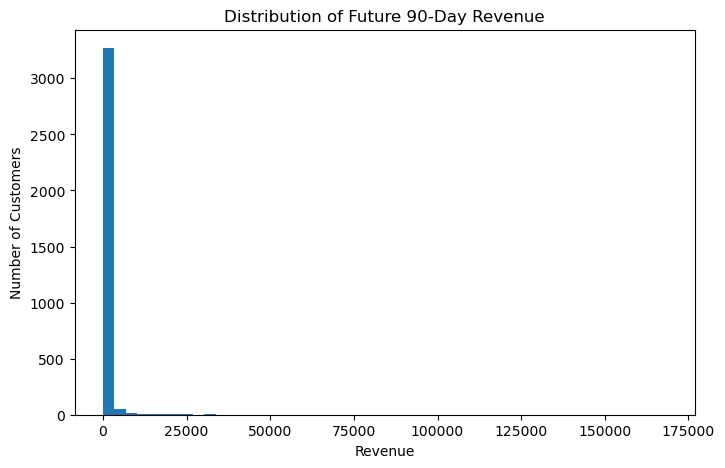

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(clv_df["Future_90d_Revenue"], bins=50)
plt.title("Distribution of Future 90-Day Revenue")
plt.xlabel("Revenue")
plt.ylabel("Number of Customers")
plt.show()


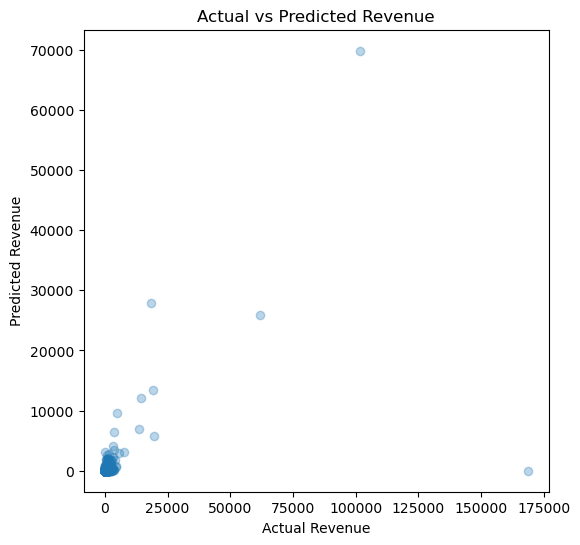

In [27]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_actual, y_pred, alpha=0.3)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
plt.show()


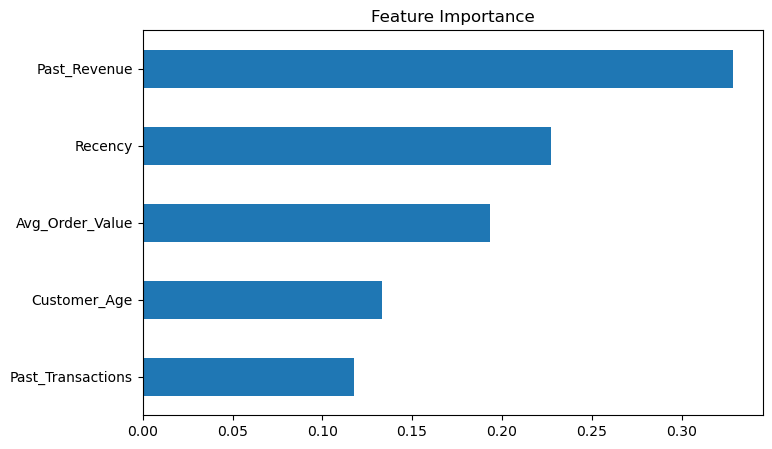

In [28]:
importance.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance")
plt.show()



## 6. Business Insights and Interpretation


### Revenue Distribution

Future revenue is highly skewed. While the mean revenue is around £846, the median is significantly lower (~£173), indicating that a small group of customers drives a large portion of revenue.

### Key Revenue Drivers

Feature importance analysis revealed:

- **Past Revenue** is the strongest predictor of future spending.
- **Recency** significantly impacts repeat purchasing probability.
- **Average Order Value** influences long-term revenue potential.

This suggests that customer purchasing behavior is persistent and predictable when historical patterns are considered.

### Customer Segmentation

Based on predicted revenue, customers were segmented into:

- High Value
- Medium Value
- Low Value

This enables businesses to:

- Prioritize retention strategies for high-value customers.
- Design targeted campaigns for medium-value customers.
- Re-engage low-value customers using personalized incentives.

## 7. Conclusion

This project demonstrates a structured approach to Customer Lifetime Value prediction using transactional data.

By combining time-aware modeling, RFM-inspired feature engineering, and regression techniques, future revenue was predicted with reasonable accuracy.

The findings highlight the importance of historical revenue and recency in forecasting customer value and provide a practical framework for data-driven marketing and customer segmentation strategies.


## Limitations and Future Improvements

- Revenue distribution is highly skewed, which affects regression accuracy.
- A two-stage model (purchase probability + spend prediction) could further improve results.
- Additional features such as product diversity or purchase frequency over time could enhance performance.
